**Project** **Title**





Drought Risk Prediction and Early-Warning Insights Extraction

**Problem** **Statement**

Droughts cause severe water scarcity and crop loss; hence, a machine learning model is needed to predict drought risk levels (Low, Medium, High) using climatic, soil, and hydrological data for early warning and planning.






**Description**

This project focuses on building a machine learning–based drought risk prediction system. The model analyzes multiple environmental indicators such as rainfall, temperature, soil moisture, vegetation index (NDVI), humidity, wind speed, river flow, elevation, and ENSO (El Niño/La Niña conditions) to classify drought risk levels as Low, Medium, or High.

By learning from past climatic and environmental data, the system provides early warning insights that can support farmers, water resource managers, and policymakers in making informed decisions. The goal is to improve drought preparedness, optimize water management, reduce agricultural losses, and ensure food security.

In [9]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os


In [10]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("drought_dataset.csv (1).csv")  # use the exact uploaded name

Saving drought_dataset.csv.csv to drought_dataset.csv (5).csv


In [11]:
# Step 2B: Basic Info about Dataset
# ---------------------------------
print("🔹 First 5 Rows of Dataset:")
print(df.head())

print("\n🔹 Dataset Shape (rows, columns):", df.shape)

print("\n🔹 Column Names:")
print(df.columns)

print("\n🔹 Data Types:")
print(df.dtypes)

print("\n🔹 Missing Values in Each Column:")
print(df.isnull().sum())

print("\n🔹 Statistical Summary (numerical columns):")
print(df.describe())


🔹 First 5 Rows of Dataset:
   Rainfall_mm  Temperature_C  Soil_Moisture  NDVI  Humidity  Wind_Speed  \
0           12             32           0.18  0.21        42          14   
1           85             27           0.62  0.48        71           9   
2           45             29           0.40  0.36        60          12   
3           10             34           0.15  0.19        38          18   
4           90             26           0.65  0.55        75           8   

   River_Flow  Elevation_m          Region        Season     ENSO Drought_Risk  
0         102          320       Telangana   Pre-Monsoon   ElNino         High  
1         215          280     Maharashtra       Monsoon  Neutral          Low  
2         175          300       Karnataka  Post-Monsoon   LaNina       Medium  
3          98          400  Andhra Pradesh   Pre-Monsoon   ElNino         High  
4         220          290         Gujarat       Monsoon  Neutral          Low  

🔹 Dataset Shape (rows, column

Saving drought_dataset.csv.csv to drought_dataset.csv (8).csv
 Loaded file: drought_dataset.csv (8).csv
   Rainfall_mm  Temperature_C  Soil_Moisture  NDVI  Humidity  Wind_Speed  \
0           12             32           0.18  0.21        42          14   
1           85             27           0.62  0.48        71           9   
2           45             29           0.40  0.36        60          12   
3           10             34           0.15  0.19        38          18   
4           90             26           0.65  0.55        75           8   

   River_Flow  Elevation_m          Region        Season     ENSO Drought_Risk  
0         102          320       Telangana   Pre-Monsoon   ElNino         High  
1         215          280     Maharashtra       Monsoon  Neutral          Low  
2         175          300       Karnataka  Post-Monsoon   LaNina       Medium  
3          98          400  Andhra Pradesh   Pre-Monsoon   ElNino         High  
4         220          290        

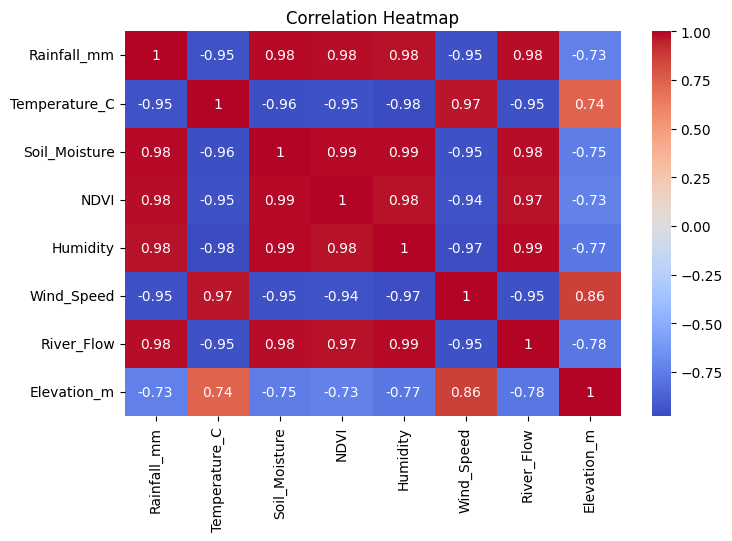

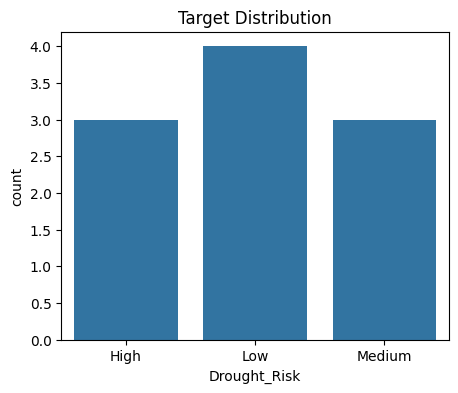


 Data transformed. Shape: (10, 23)


In [17]:
# Step 1: Upload + Load dataset
from google.colab import files
import pandas as pd
import io
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(" Loaded file:", filename)
print(df.head())

#Step 2: Exploratory Data Analysis (EDA)

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Summary Statistics ---")
print(df.describe(include="all"))

# Correlation heatmap (only numeric)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x="Drought_Risk", data=df)
plt.title("Target Distribution")
plt.show()

# Step 3: Data Transformation
num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols.remove("Elevation_m") if "Elevation_m" in num_cols else None  # optional
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
target = "Drought_Risk"

if target in num_cols: num_cols.remove(target)
if target in cat_cols: cat_cols.remove(target)

X = df.drop(columns=[target])
y = df[target]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_transformed = preprocess.fit_transform(X)
print("\n Data transformed. Shape:", X_transformed.shape)


--- Top Features ---
                    Feature  Importance
4             num__Humidity    0.123437
3                 num__NDVI    0.092098
7          num__Elevation_m    0.088659
5           num__Wind_Speed    0.082237
2        num__Soil_Moisture    0.081292
6           num__River_Flow    0.080437
0          num__Rainfall_mm    0.072831
18         cat__ENSO_ElNino    0.057210
20        cat__ENSO_Neutral    0.052621
17  cat__Season_Pre-Monsoon    0.050756


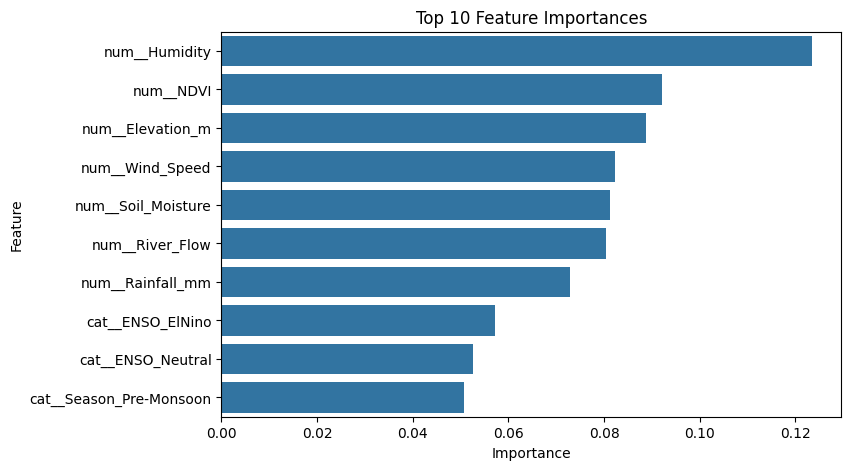

In [18]:


# Step 4: Feature Selection

# Define numerical & categorical columns
num_cols = ["Rainfall_mm", "Temperature_C", "Soil_Moisture", "NDVI",
            "Humidity", "Wind_Speed", "River_Flow", "Elevation_m"]
cat_cols = ["Region", "Season", "ENSO"]

# Preprocessing: scale numeric + encode categorical
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Pipeline: preprocessing + RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
pipe = Pipeline(steps=[("prep", preprocess), ("model", rf)])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit pipeline
pipe.fit(X_train, y_train)

# Get feature names after transformation
feature_names = pipe.named_steps["prep"].get_feature_names_out()
importances = pipe.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\n--- Top Features ---")
print(feat_imp.head(10))

# Plot top features
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Top 10 Feature Importances")
plt.show()

Saving drought_dataset.csv.csv to drought_dataset.csv (9).csv
 Dataset Loaded Successfully!
   Rainfall_mm  Temperature_C  Soil_Moisture  NDVI  Humidity  Wind_Speed  \
0           12             32           0.18  0.21        42          14   
1           85             27           0.62  0.48        71           9   
2           45             29           0.40  0.36        60          12   
3           10             34           0.15  0.19        38          18   
4           90             26           0.65  0.55        75           8   

   River_Flow  Elevation_m          Region        Season     ENSO Drought_Risk  
0         102          320       Telangana   Pre-Monsoon   ElNino         High  
1         215          280     Maharashtra       Monsoon  Neutral          Low  
2         175          300       Karnataka  Post-Monsoon   LaNina       Medium  
3          98          400  Andhra Pradesh   Pre-Monsoon   ElNino         High  
4         220          290         Gujarat    

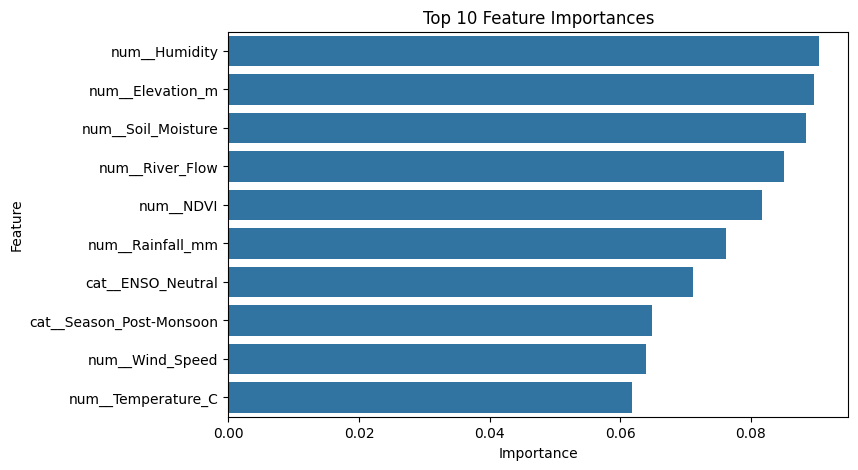


🔹 RandomForest Model Results 🔹
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         1
         Low       1.00      1.00      1.00         1
      Medium       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Confusion Matrix:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]

🔹 GradientBoosting Model Results 🔹
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         1
         Low       1.00      1.00      1.00         1
      Medium       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Confusion Matrix:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]

 RandomForest Cross-Validat

In [19]:
# =====================================================
# Step 0: Upload & Load Dataset Again
# =====================================================
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
filename = list(uploaded.keys())[0]   # get uploaded file name
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(" Dataset Loaded Successfully!")
print(df.head())
# =====================================================
# Step 4: Feature Selection
# =====================================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestClassifier

# Define numerical & categorical columns
num_cols = ["Rainfall_mm", "Temperature_C", "Soil_Moisture", "NDVI",
            "Humidity", "Wind_Speed", "River_Flow", "Elevation_m"]
cat_cols = ["Region", "Season", "ENSO"]

# Preprocessing: scale numeric + encode categorical
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Pipeline: preprocessing + RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
pipe = Pipeline(steps=[("prep", preprocess), ("model", rf)])

#  Define X and y
X = df.drop("Drought_Risk", axis=1)
y = df["Drought_Risk"]

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Fit pipeline
pipe.fit(X_train, y_train)

# Get feature names after transformation
feature_names = pipe.named_steps["prep"].get_feature_names_out()
importances = pipe.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\n--- Top Features ---")
print(feat_imp.head(10))

# Plot top features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Top 10 Feature Importances")
plt.show()

# =====================================================
# Step 5: Model Training
# =====================================================
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

for name, model in models.items():
    clf = Pipeline(steps=[("prep", preprocess), ("model", model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n🔹 {name} Model Results 🔹")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# =====================================================
# Step 6: Cross-Validation (RandomForest)
# =====================================================
rf_clf = Pipeline(steps=[("prep", preprocess), ("model", rf)])
scores = cross_val_score(rf_clf, X, y, cv=3) # Reduced cv to 3
print("\n RandomForest Cross-Validation Accuracy:", scores.mean())
# =====================================================
# Step 7: Model Evaluation with Cross-Validation
# =====================================================
from sklearn.model_selection import StratifiedKFold

# Define StratifiedKFold with 3 splits (safe for small datasets)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_clf = Pipeline(steps=[("prep", preprocess), ("model", rf)])
scores = cross_val_score(rf_clf, X, y, cv=cv)

print("\n RandomForest Cross-Validation Accuracy:", scores.mean())

# =====================================================
# Step 7: Save Best Model
# =====================================================
import joblib # Import joblib
best_model = rf_clf.fit(X, y)
joblib.dump(best_model, "drought_prediction_model.pkl")
print("\n Model Saved as drought_prediction_model.pkl")

In [20]:
# =====================================================
# Step 8: Prediction on New Data (Demo)
# =====================================================
import joblib
import pandas as pd

# Load the saved model
loaded_model = joblib.load("drought_prediction_model.pkl")
print(" Model Loaded Successfully!")

# Example new data (replace with real values as needed)
new_data = pd.DataFrame([{
    "Rainfall_mm": 120,
    "Temperature_C": 28,
    "Soil_Moisture": 0.25,
    "NDVI": 0.62,
    "Humidity": 70,
    "Wind_Speed": 12,
    "River_Flow": 450,
    "Elevation_m": 320,
    "Region": "South",
    "Season": "Summer",
    "ENSO": "Neutral"
}])

# Make prediction
prediction = loaded_model.predict(new_data)
print("\n Predicted Drought Risk:", prediction[0])


 Model Loaded Successfully!

 Predicted Drought Risk: Low


In [16]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

model = joblib.load("drought_prediction_model.pkl")

st.title("🌱 Drought Prediction App (Colab)")
st.write("Enter environmental conditions to predict drought risk.")

rainfall = st.number_input("Rainfall (mm)", 0.0, 1000.0, 120.0)
temperature = st.number_input("Temperature (°C)", -10.0, 60.0, 28.0)
soil_moisture = st.number_input("Soil Moisture", 0.0, 1.0, 0.25)
ndvi = st.number_input("NDVI", 0.0, 1.0, 0.62)

region = st.selectbox("Region", ["North", "South", "East", "West"])
season = st.selectbox("Season", ["Summer", "Winter", "Monsoon"])
enso = st.selectbox("ENSO", ["El-Nino", "La-Nina", "Neutral"])

input_data = pd.DataFrame([{
    "Rainfall_mm": rainfall,
    "Temperature_C": temperature,
    "Soil_Moisture": soil_moisture,
    "NDVI": ndvi,
    "Humidity": 70,
    "Wind_Speed": 12,
    "River_Flow": 450,
    "Elevation_m": 320,
    "Region": region,
    "Season": season,
    "ENSO": enso
}])

if st.button("Predict"):
    prediction = model.predict(input_data)
    st.write(f"✅ Predicted Risk: **{prediction[0]}**")


Writing app.py
